In [1]:
%matplotlib inline

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from envs.gridworld import GridWorld

env = GridWorld(5, 2)

from IPython import display
plt.ion()

# if gpu is to be used
device = torch.device("cpu")

---
### Helper functions

In [2]:
def plot_durations(episode_durations, internal_dur, goal_hit):
    fig, axs = plt.subplots(3, figsize=(10,10))
    
    durations_t, durations = list(map(list, zip(*episode_durations)))
    durations = torch.tensor(durations, dtype=torch.float)
    
    fig.suptitle('Training')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Reward')
    axs[1].set_xlabel('Step')
    axs[1].set_ylabel('Internal reward')
    axs[2].set_xlabel('Step')
    axs[2].set_ylabel('Goal hit')
    
    axs[0].plot(durations_t, durations.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        axs[0].plot(durations_t, means.numpy())
        
    durations_t, durations = list(map(list, zip(*internal_dur)))
    durations = torch.tensor(durations, dtype=torch.float)
    #axs[1].plot(durations_t, durations.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 1000:
        means = durations.unfold(0, 1000, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(999), means))
        axs[1].plot(durations_t, means.numpy())
    
    durations_t, durations = list(map(list, zip(*goal_hit)))
    durations = torch.tensor(durations, dtype=torch.float)
    axs[2].plot(durations_t, durations.numpy())
    if len(durations_t) >= 100:
        means = durations.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        axs[2].plot(durations_t, means.numpy())
        
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)

In [8]:
def save_model(epoch, model, episode_durations, internal_dur, goal_hit):
    model_save_name = 'saved_models/hdqn_gridworld_5x2.pt'
    path = f"{model_save_name}" 

    torch.save({
        'steps': epoch,
        'episode_durations': episode_durations,
        'internal_dur': internal_dur,
        'goal_hit': goal_hit,
        'meta_controller_state_dict': model.meta_controller.state_dict(),
        'controller_state_dict': model.controller.state_dict(),
        'meta_controller_memory': model.meta_controller.memory,
        'controller_memory': model.controller.memory
    }, path)
    
def load_model(model, name='saved_models/hdqn_gridworld_5x2.pt'):
    model_save_name = name
    path = f"{model_save_name}" 
    checkpoint = torch.load(path)

    model.meta_controller.load_state_dict(checkpoint['meta_controller_state_dict'])
    model.controller.load_state_dict(checkpoint['controller_state_dict'])
    
    model.meta_controller_target.load_state_dict(model.meta_controller.state_dict())
    model.controller_target.load_state_dict(model.controller.state_dict())
    
    model.meta_controller.memory = checkpoint['meta_controller_memory']
    model.controller.memory = checkpoint['controller_memory']
    
    model.meta_controller.pretrain = False

    # model.eval() for evaluation instead
    model.train()
    
    # todo: copy checkpoint things and then do
    # del checkpoint
    
    steps, episode_durations, internal_dur, goal_hit = np.array(checkpoint['steps'], copy=True), np.array(checkpoint['episode_durations'], copy=True), np.array(checkpoint['internal_dur'], copy=True), np.array(checkpoint['goal_hit'], copy=True)
    del checkpoint
    return steps, episode_durations, internal_dur, goal_hit

---
### Code

In [4]:
# (state, action) -> (next_state, reward, done)
transition = namedtuple('transition', ('state', 'action', 'next_state', 'reward', 'done'))

# replay memory D with capacity N
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    # implemented as a cyclical queue
    def store(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        self.memory[self.position] = transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
BATCH_SIZE = 128
GAMMA = 0.99

class DQN(nn.Module):
    def __init__(self, inputs, outputs, mem_len = 100000):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.head = nn.Linear(128, outputs)
        
        self.memory = ReplayMemory(mem_len)

        self.n_actions = outputs
        self.steps_done = 0
        
        self.EPS_START = 1
        self.EPS_END = 0.1
        self.EPS_DECAY = 50000 # in number of steps
        
        self.pretrain = False

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.head(x)
    
    def act(self, state):
        if self.pretrain:
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)
        
        #eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * (1. - min(1., self.steps_done / self.EPS_DECAY))
        eps_threshold = 0.2
            
        self.steps_done += 1

        # With probability eps select a random action
        if random.random() < eps_threshold:
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)

        # otherwise select action = maxa Q∗(φ(st), a; θ)
        with torch.no_grad():
            return self(state).max(1)[1].view(1, 1)
    
    def experience_replay(self, optimizer, target):
        if len(self.memory) < BATCH_SIZE or self.pretrain:
            return
        
        # in the form (state, action) -> (next_state, reward, done)
        transitions = self.memory.sample(BATCH_SIZE)
        batch = transition(*zip(*transitions))
        
        state_batch = torch.cat(batch.state)
        next_state_batch = torch.cat(batch.next_state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        done_mask = np.array(batch.done)
        not_done_mask = torch.from_numpy(1 - done_mask).float().to(device)
        
        current_Q_values = self(state_batch).gather(1, action_batch)

        next_max_q = target(next_state_batch).max(1)[0].detach()
        
        next_Q_values = not_done_mask * next_max_q
        
        # Compute the target of the current Q values
        target_Q_values = reward_batch + (GAMMA * next_Q_values)
        
        # Compute Bellman error (using Huber loss)
        loss = F.smooth_l1_loss(current_Q_values, target_Q_values.unsqueeze(1))
        
        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        for param in self.parameters():
            param.grad.data.clamp_(-1, 1)
        optimizer.step()
        
class HDQN(nn.Module):
    def __init__(self, inputs, positions, outputs):
        super(HDQN, self).__init__()
        
        self.meta_controller = DQN(inputs, positions, mem_len = 10000 * 200).to(device)
        self.meta_controller.EPS_DECAY = 5000
        self.meta_controller.pretrain = True
        self.meta_controller_optimizer = optim.Adam(self.meta_controller.parameters(), lr = 0.001)
        self.meta_controller_target = DQN(inputs, positions, mem_len = 0).to(device)
        self.meta_controller_target.eval()
        
        # append goal state to inputs
        self.controller = DQN(inputs + 1, outputs, mem_len = 10000 * 200).to(device)
        self.controller_optimizer = optim.Adam(self.controller.parameters(), lr = 0.001)
        self.controller_target = DQN(inputs + 1, outputs, mem_len = 0).to(device)
        self.controller_target.eval()
    
    def store_controller(self, *args):
        self.controller.memory.store(*args)
    
    def store_meta_controller(self, *args):
        self.meta_controller.memory.store(*args)
    
    def select_goal(self, external_observation):
        return self.meta_controller.act(external_observation)
        
    def select_action(self, joint_goal_obs):
        return self.controller.act(joint_goal_obs)
    
    def experience_replay(self):
        self.meta_controller.experience_replay(self.meta_controller_optimizer, self.meta_controller_target)
        self.controller.experience_replay(self.controller_optimizer, self.controller_target)

In [6]:
import time
def train_model():
    # Get number of actions and observations from gym action space
    n_actions = env.action_space.n
    n_observations = env.observation_space.shape[0]
    n_positions = env.num_positions

    # Initialize action-value function Q with random weights
    hdqnAgent = HDQN(n_observations, n_positions, n_actions).to(device)

    num_episodes = 10000 # M
    episode_durations = []
    internal_dur = []
    goal_hit = []
    last_saved = 0
    steps = 0
    
    steps, episode_durations, internal_dur, goal_hit = load_model(hdqnAgent)
    last_ep = episode_durations[-1][0]
    last_saved = last_ep
    
    for i_episode in range(last_ep + 1, last_ep + num_episodes):
        if i_episode >= 1000:
            hdqnAgent.meta_controller.pretrain = False
        
        observation = env.reset()

        state = torch.from_numpy(observation).float().unsqueeze(0).to(device)

        overall_reward = 0
        done = False
        goals_hit = 0
        while not done:
            # select a goal
            goal = hdqnAgent.select_goal(state)
            goal_i = goal.item()

            goal_done = False
            total_extrinsic = 0
            s_0 = state
            while not done and not goal_done:
                joint_goal_state = torch.cat([goal, state], axis=1)
                
                action = hdqnAgent.select_action(joint_goal_state)
                action_i = action.item()

                observation, reward, done, _ = env.step(action_i)
                steps += 1
                extrinsic_reward = torch.tensor([reward], device=device, dtype=torch.float)
                
                #display.clear_output(wait=True)
                #print(observation, reward)
                #env.render()
                #time.sleep(0.3)

                overall_reward += reward
                total_extrinsic += reward

                # preprocess φ_{t+1} = φ(s_{t+1})
                next_state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                joint_next_state = torch.cat([goal, next_state], axis=1)

                # check that goal was achieved (first index of observation is player position)
                goal_done = (goal_i == observation[0])
                
                if goal_done:
                    goals_hit += 1
                
                # calculate intrinsic reward as distance from player to goal
                opc = env.pos_to_coord(state[0][0].item())
                npc = env.pos_to_coord(observation[0])
                gc = env.pos_to_coord(goal_i)
                #intrinsic_reward = 1.0 if math.dist(npc, gc) <= math.dist(opc, gc) else -1.0 
                #intrinsic_reward = 1.0 / (1 + math.dist(npc, gc))
                intrinsic_reward = 1.0 if goal_done else -1.0
                internal_dur.append((steps, intrinsic_reward))

                intrinsic_reward = torch.tensor([intrinsic_reward], device=device, dtype=torch.float)

                # Store transition (φt, at, rt, φt+1) in D
                hdqnAgent.store_controller(joint_goal_state, action, joint_next_state, intrinsic_reward, done)

                state = next_state

                hdqnAgent.experience_replay()

            # Store transition for meta controller
            if not hdqnAgent.meta_controller.pretrain:
                hdqnAgent.store_meta_controller(s_0, goal, next_state, torch.tensor([total_extrinsic], device=device, dtype=torch.float), done)
                hdqnAgent.experience_replay()
                
        if i_episode % 10 == 0:
            hdqnAgent.meta_controller_target.load_state_dict(hdqnAgent.meta_controller.state_dict())
            hdqnAgent.controller_target.load_state_dict(hdqnAgent.controller.state_dict())
            
        episode_durations.append((i_episode, overall_reward))
        goal_hit.append((i_episode, goals_hit))
        
        if i_episode - last_saved >= 1000:
            last_saved = i_episode
            save_model(steps, hdqnAgent, episode_durations, internal_dur, goal_hit)
        
        plot_durations(episode_durations, internal_dur, goal_hit)

    return hdqnAgent

In [ ]:
def eval_model(hdqnAgent, episode_durations):
    hdqnAgent.eval()
    hdqnAgent.meta_controller.eval()
    hdqnAgent.controller.eval()

    num_episodes = 100

    for l2norm in range(20):

        overall_reward = 0
        for i_episode in range(num_episodes):
            observation = env.reset()

            state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
            #state = state * (np.ones(3) + (l2norm/10)*(np.random.random(3) - 0.5))
            #state = state.float()

            done = False
            while not done:
                # select a goal
                goal = hdqnAgent.select_goal(state)
                goal_i = goal.item()

                goal_done = False
                while not done and not goal_done:
                    joint_goal_state = torch.cat([goal, state], axis=1)

                    action = hdqnAgent.select_action(joint_goal_state)
                    action_i = action.item()
                    observation, reward, done, _ = env.step(action_i)

                    overall_reward += reward

                    goal_done = (goal_i == observation[0])

                    state = torch.from_numpy(observation).float().unsqueeze(0).to(device)
                    #state = state * (np.ones(3) + (l2norm/10)*(np.random.random(3) - 0.5))
                    #state = state.float()

        episode_durations[l2norm].append(overall_reward / num_episodes)

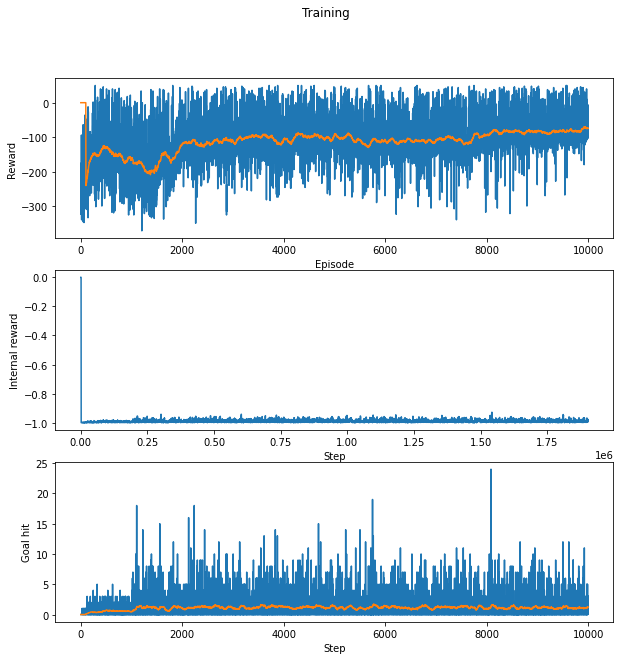

In [ ]:
agent = train_model()

In [ ]:
# intrinsic_reward = 1.0 if goal_done else -1.0

In [9]:
n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]
n_positions = env.num_positions

# Initialize action-value function Q with random weights
hdqnAgent = HDQN(n_observations, n_positions, n_actions).to(device)
steps, episode_durations, internal_dur, goal_hit = load_model(hdqnAgent, 'saved_models/hdqn_gridworld_5x2_8k.pt')

In [ ]:
save_model(0, agent)

In [ ]:
def plot_norms(episode_durations):
    plt.figure(2, figsize=(10,10))
    
    x, ys = np.array(list(episode_durations.keys())), np.array(list(episode_durations.values()))
    
    plt.title('Action Prediction $\mu$ and $\pm \sigma$ interval')
    plt.xlabel('L2 Norm')
    plt.ylabel('Average Reward')
    
    mu = np.mean(ys, axis=1)
    plt.plot(x / 10, mu)
    stds = np.std(ys, axis = 1)
    plt.fill_between(x / 10, mu + stds , mu - stds, alpha=0.2)
        
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)

In [ ]:
episode_durations = {}
for l2norm in range(20):
    episode_durations[l2norm] = []

eval_model(agent, episode_durations)
plot_norms(episode_durations)